In [61]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import statsmodels.api as sm

In [62]:
def label_campaign(date: pd.Timestamp):
    if date < pd.Timestamp("2022-04-07") and date >= pd.Timestamp("2022-02-24"):
        return "Initial Invasion"
    elif date < pd.Timestamp("2022-08-28"):
        return "Souteastern Front"
    elif date < pd.Timestamp("2022-11-11"):
        return "Counteroffensive"
    elif date < pd.Timestamp("2023-03-28"):
        return "First Stalemate"
    elif date <= pd.Timestamp("2023-10-08"):
        return "Second Stalemate"
    else:
        return pd.NA

In [63]:
df_russia_losses = pd.read_csv("./russia_losses_personnel.csv", index_col=0, parse_dates=[0])
df_russia_losses["campaign"] = df_russia_losses.index.map(label_campaign)
df_aid = pd.read_csv("./ua_aid_revised.csv", parse_dates=[0], index_col=0)
df_all = df_russia_losses.merge(df_aid, left_index=True, right_index=True, how="left").fillna(0)

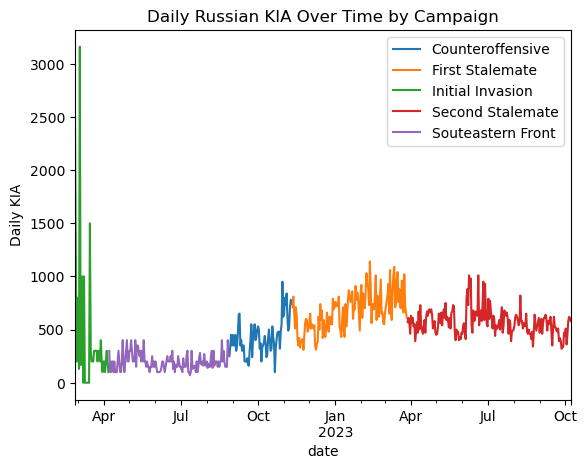

In [64]:
df_all.groupby("campaign")["daily_total"].plot(
    ylabel="Daily KIA",
    title="Daily Russian KIA Over Time by Campaign"
)
plt.legend()

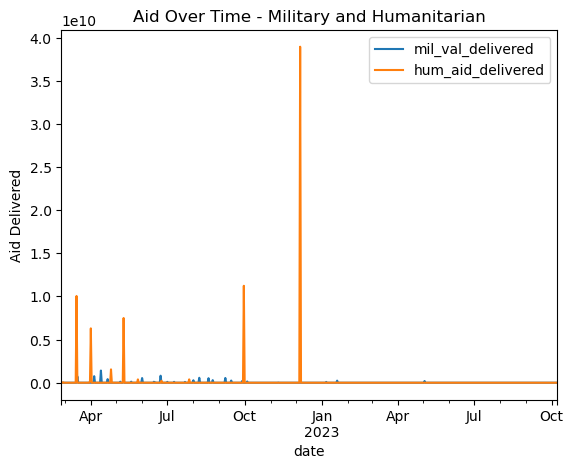

In [65]:
df_all[["mil_val_delivered", "hum_aid_delivered"]].plot(
    ylabel="Aid Delivered",
    title="Aid Over Time - Military and Humanitarian"
)
plt.legend()

In [66]:
     
df_aid_kia = (
    df_all[["total", "daily_total"]]
    .rename(columns={"total": "total_aid", "daily_total": "total_kia"})
    .fillna(0)
)

Text(0, 0.5, 'Total KIA')

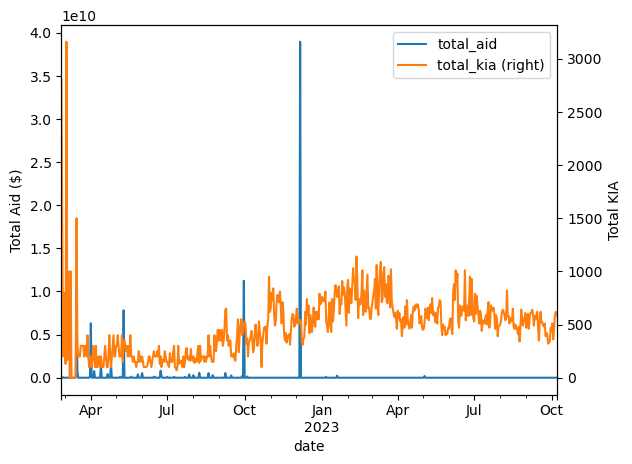

In [67]:


ax = df_aid_kia[["total_aid", "total_kia"]].plot(
    label="Aid recieved (per day)",
    secondary_y=["total_kia"]
)
ax.set_ylabel("Total Aid ($)")
plt.ylabel("Total KIA")



In [68]:
# get rid of the initial days, since these are likely distributed quite different from the sustained war
april2022_onwards = df_aid_kia.index > pd.Timestamp("2022-04-01")

df_aid_kia = df_aid_kia[april2022_onwards]

Text(0, 0.5, 'Total KIA')

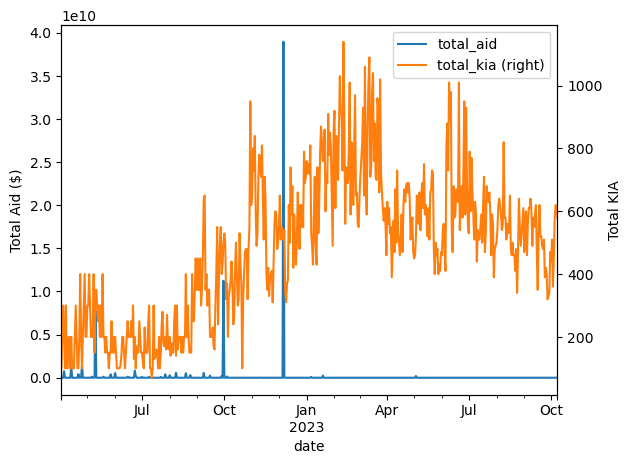

In [69]:


ax = df_aid_kia[["total_aid", "total_kia"]].plot(
    label="Aid recieved (per day)",
    secondary_y=["total_kia"]
)
ax.set_ylabel("Total Aid ($)")
plt.ylabel("Total KIA")



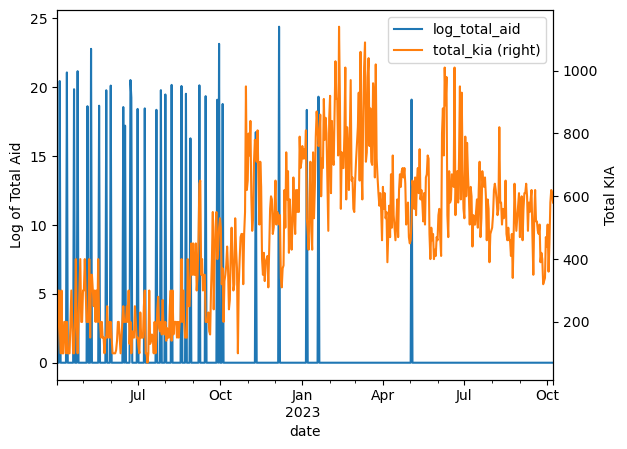

In [70]:
#Not sure if this is better...

# It's big, it's heavy, it's wood, it's better than bad, it's good
df_aid_kia["log_total_aid"] = np.log1p(df_aid_kia["total_aid"])

# Plot using the log transformation of total_aid
ax = df_aid_kia[["log_total_aid", "total_kia"]].plot(
    label="Log of Aid received (per day)",
    secondary_y=["total_kia"]
)
ax.set_ylabel("Log of Total Aid")
plt.ylabel("Total KIA")
plt.show()


In [71]:
def plot_and_fit(df_aid_kia: pd.DataFrame, aid_shift: int=0, freq: str="3W"):
    # Make a copy of the input dataframe, so that we don't change the original one below.
    df_aid_kia_copy = df_aid_kia[["total_aid", "total_kia"]].copy()

    # check that the time axis has a value for every day, or else the `shift` won't work
    # (there's probably a simpler way to code this)
    nanoseconds_in_one_day = 24*60*60*1e9
    assert np.all(df_aid_kia.index.to_series().diff().dropna().unique() == pd.to_timedelta(nanoseconds_in_one_day))

    # If requested, shift the aid data by `aid_shift`. If there is always 1 point per day
    # you will shift by `aid_shift` days.
    # When we do the regression, we will then be fitting on whether there is a lag of
    # `aid_shift` between when aid arrives and when KIA raet goes up.
    if aid_shift:
        df_aid_kia_copy["total_aid"] = df_aid_kia_copy["total_aid"].shift(aid_shift)
        df_aid_kia_copy = df_aid_kia_copy.dropna()


    # Get the cululative aid over time (rather than aid on any given day)
    # Then group by some amount of time (in this function in panads, "3W" is 3 weeks,
    # "1M" would be 1 month, etc).
    # NB: the last data point in the series might not be a full time window, so it might
    # have lower sums.
    # NB 2: we need to have the cumsum after the grouping step to count correctly.
    aid = (
        df_aid_kia_copy["total_aid"]
        .groupby(pd.Grouper(freq=freq)).sum()
        .cumsum()
    )

    # Group KIAs by the same grouping of time.
    kia = (
        df_aid_kia_copy["total_kia"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    # Plot this new transform of the data.
    ax = aid.plot()
    kia.plot(ax=ax, secondary_y=True)
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    ax.right_ax.set_ylabel('KIA per day')
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = aid
    y = kia
    model2 = LinearRegression()
    model2.fit(X.values.reshape(-1, 1), y.values)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X.values, y.values, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model2.coef_*X_fit + model2.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    plt.ylabel('KIA per day')

    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"coefficient: {model2.coef_[0]}")
    print(f"intercept: {model2.intercept_}")
    
    # Note that the Statsmodels approach gives the same result and is
    # a little more R-like
    print("\n\nStatsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)\n")
    mod = sm.OLS(y, sm.add_constant(X))
    res = mod.fit()
    print(res.summary())

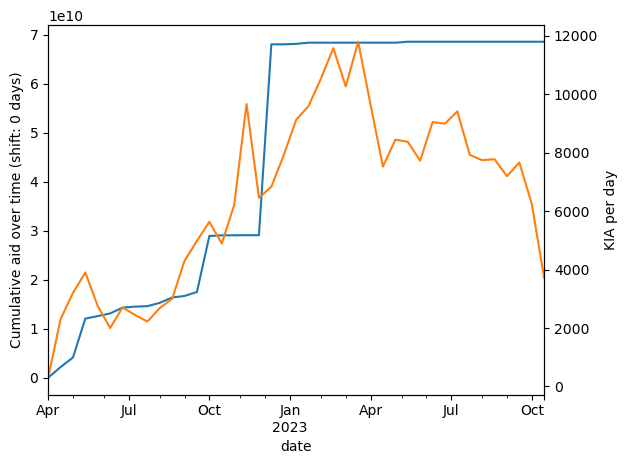

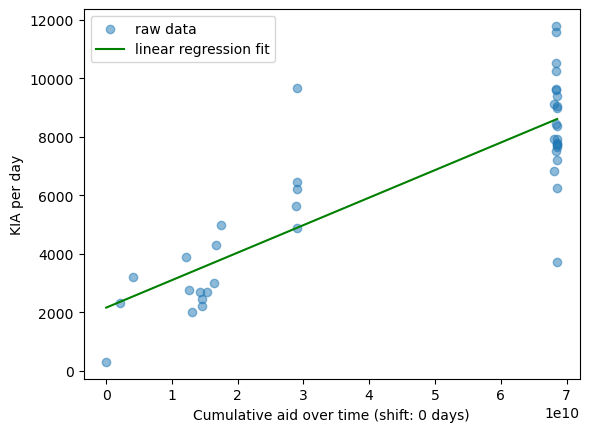

coefficient: 9.407742622322782e-08
intercept: 2156.6568849822843


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)

                            OLS Regression Results                            
Dep. Variable:              total_kia   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     90.33
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           1.06e-11
Time:                        21:58:18   Log-Likelihood:                -361.51
No. Observations:                  41   AIC:                             727.0
Df Residuals:                      39   BIC:                             730.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [72]:
plot_and_fit(df_aid_kia, aid_shift=0, freq="2W")


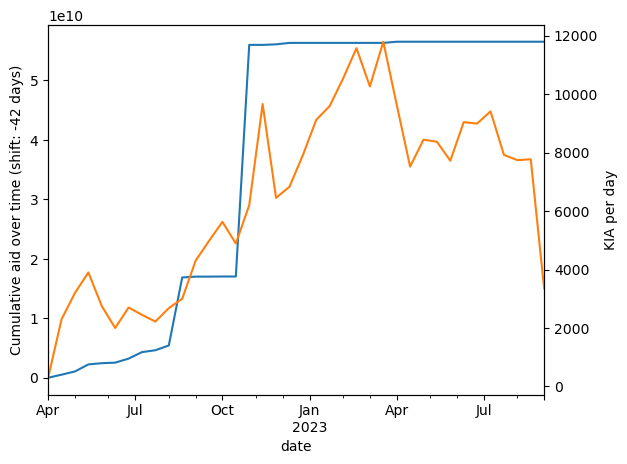

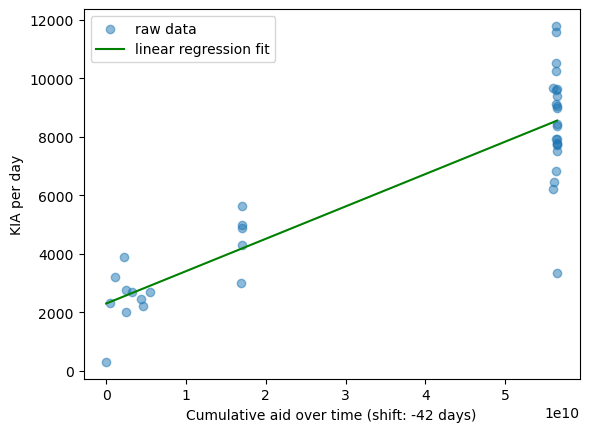

coefficient: 1.1071046716158551e-07
intercept: 2296.612200409756


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)

                            OLS Regression Results                            
Dep. Variable:              total_kia   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     113.6
Date:                Sat, 18 Nov 2023   Prob (F-statistic):           1.10e-12
Time:                        21:58:20   Log-Likelihood:                -332.21
No. Observations:                  38   AIC:                             668.4
Df Residuals:                      36   BIC:                             671.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [

In [73]:
plot_and_fit(df_aid_kia, aid_shift=-42, freq="2W")

In [74]:
# Specify the file path 
csv_file_path = "/Users/test/Desktop/Capstone/ua_civ_cas.csv"

# Read the CSV file into a DataFrame
ua_civ_cas = pd.read_csv(csv_file_path, parse_dates=["date"], dtype={"civ_kill": int})

# Print the structure of the DataFrame
print(ua_civ_cas.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      18 non-null     datetime64[ns]
 1   civ_kill  18 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 416.0 bytes
None


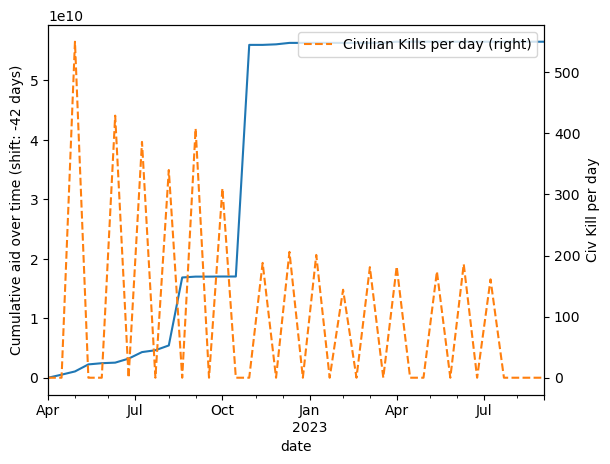

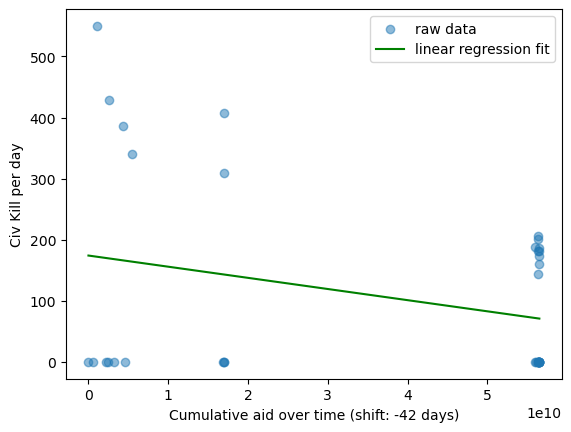

coefficient for total_aid: -1.826240066233224e-09
intercept: 174.12696653335843


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     3.357
Date:                Sat, 18 Nov 2023   Prob (F-statistic):             0.0752
Time:                        22:28:00   Log-Likelihood:                -243.14
No. Observations:                  38   AIC:                             490.3
Df Residuals:                      36   BIC:                             493.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t   

In [83]:
def plot_and_fit_civ_kill(df_combined, aid_shift=0, freq="3W"):
    # Make a copy of the input dataframe
    df_combined_copy = df_combined[["total_aid", "civ_kill"]].copy()

    # Convert the index to DatetimeIndex
    df_combined_copy.index = pd.to_datetime(df_combined_copy.index)

    # If requested, shift the aid data by `aid_shift`.
    if aid_shift:
        df_combined_copy["total_aid"] = df_combined_copy["total_aid"].shift(aid_shift)
        df_combined_copy = df_combined_copy.dropna()

    # Get the cumulative aid over time
    aid = (
        df_combined_copy["total_aid"]
        .groupby(pd.Grouper(freq=freq)).sum()
        .cumsum()
    )

    # Group civilian kills by the same grouping of time.
    civ_kill = (
        df_combined_copy["civ_kill"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    # Plot this new transform of the data.
    ax = aid.plot()
    civ_kill.plot(ax=ax, secondary_y=True, linestyle="--", label="Civilian Kills per day")
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    ax.right_ax.set_ylabel('Civ Kill per day')
    plt.legend()
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = aid.values.reshape(-1, 1)
    y = civ_kill.values
    model_civ_kill = LinearRegression()
    model_civ_kill.fit(X, y)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X, y, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model_civ_kill.coef_[0] * X_fit + model_civ_kill.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    plt.ylabel('Civ Kill per day')
    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"coefficient for total_aid: {model_civ_kill.coef_[0]}")
    print(f"intercept: {model_civ_kill.intercept_}")

    # Note that the Statsmodels approach gives the same result and is
    # a little more R-like
    print("\n\nStatsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)\n")
    mod = sm.OLS(y, sm.add_constant(X))
    res = mod.fit()
    print(res.summary())

# Plot and fit with the combined DataFrame
plot_and_fit_civ_kill(df_combined, aid_shift=-42, freq="2W")



In [78]:
# Function to plot and fit
def plot_and_fit_combined(df_combined, aid_shift=0, freq="3W"):
    # Make a copy of the input dataframe, so that we don't change the original one below.
    df_combined_copy = df_combined[["total_aid", "total_kia", "civ_kill"]].copy()

    # Convert the index to DatetimeIndex
    df_combined_copy.index = pd.to_datetime(df_combined_copy.index)

    # check that the time axis has a value for every day, or else the `shift` won't work
    nanoseconds_in_one_day = 24*60*60*1e9
    assert pd.to_datetime(df_combined_copy.index).to_numpy().astype(int).diff().dropna().unique().item() == nanoseconds_in_one_day

    # If requested, shift the aid data by `aid_shift`. If there is always 1 point per day
    # you will shift by `aid_shift` days.
    # When we do the regression, we will then be fitting on whether there is a lag of
    # `aid_shift` between when aid arrives and when KIA rate goes up.
    if aid_shift:
        df_combined_copy["total_aid"] = df_combined_copy["total_aid"].shift(aid_shift)
        df_combined_copy = df_combined_copy.dropna()

    # Get the cumulative aid over time (rather than aid on any given day)
    # Then group by some amount of time (in this function in pandas, "3W" is 3 weeks,
    # "1M" would be 1 month, etc).
    aid = (
        df_combined_copy["total_aid"]
        .groupby(pd.Grouper(freq=freq)).sum()
        .cumsum()
    )

    # Group KIAs and civilian kills by the same grouping of time.
    kia = (
        df_combined_copy["total_kia"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    civ_kill = (
        df_combined_copy["civ_kill"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    # Plot this new transform of the data.
    ax = aid.plot()
    kia.plot(ax=ax, secondary_y=True, label="KIA per day")
    civ_kill.plot(ax=ax, secondary_y=True, linestyle="--", label="Civilian Kills per day")
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    ax.right_ax.set_ylabel('KIA per day / Civ Kill per day')
    plt.legend()
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = aid
    y = kia
    civ_y = civ_kill
    model_combined = LinearRegression()
    model_combined.fit(np.column_stack((X, civ_y)), y)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X.values, y.values, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model_combined.coef_[0]*X_fit + model_combined.coef_[1]*civ_y.mean() + model_combined.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    plt.ylabel('KIA per day')
    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"coefficient for total_aid: {model_combined.coef_[0]}")
    print(f"coefficient for civ_kill: {model_combined.coef_[1]}")
    print(f"intercept: {model_combined.intercept_}")

    # Note that the Statsmodels approach gives the same result and is
    # a little more R-like
    print("\n\nStatsmodels gives the same coefficients (`total_aid` and `civ_kill`) / intercept (`coefficient`)\n")
    mod = sm.OLS(y, sm.add_constant(np.column_stack((X, civ_y))))
    res = mod.fit()
    print(res.summary())

# Plot and fit with the combined DataFrame
plot_and_fit_combined(df_combined, aid_shift=-42, freq="2W")


AttributeError: 'numpy.ndarray' object has no attribute 'diff'

In [80]:
# Specify the file path
gain_loss_file_path = "/Users/test/Desktop/Capstone/ua_gain_loss.csv" 

# Read the CSV file into a DataFrame
ua_gain_loss = pd.read_csv(gain_loss_file_path, parse_dates=["date"])

# Print the structure of the DataFrame
print(ua_gain_loss.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    18 non-null     datetime64[ns]
 1   r_gain  18 non-null     int64         
 2   r_loss  18 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 560.0 bytes
None


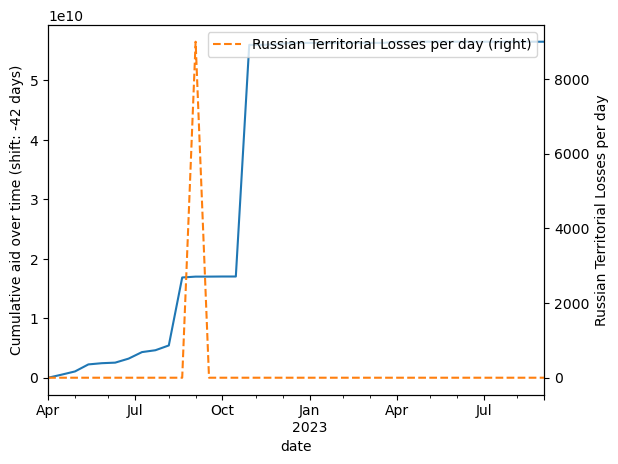

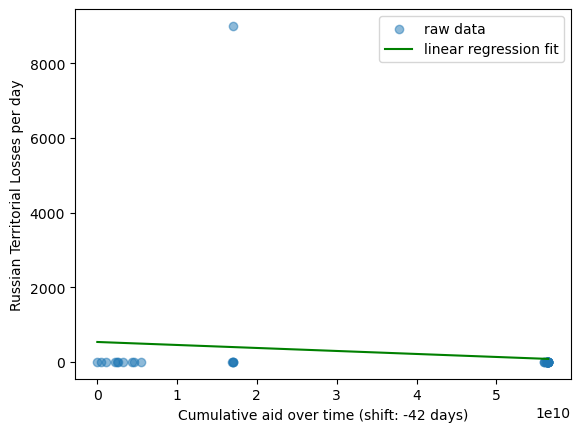

coefficient for total_aid: -8.028079119229757e-09
intercept: 534.2432592546633


Statsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.6734
Date:                Sat, 18 Nov 2023   Prob (F-statistic):              0.417
Time:                        22:32:52   Log-Likelihood:                -329.94
No. Observations:                  38   AIC:                             663.9
Df Residuals:                      36   BIC:                             667.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

In [85]:
# Merge ua_gain_loss with df_aid_kia
df_combined_gain_loss = df_aid_kia.merge(ua_gain_loss.set_index("date"), left_index=True, right_index=True, how="left").fillna(0)

# Function to plot and fit
def plot_and_fit_r_loss(df_combined_gain_loss, aid_shift=0, freq="3W"):
    # Make a copy of the input dataframe
    df_combined_copy = df_combined_gain_loss[["total_aid", "r_loss"]].copy()

    # Convert the index to DatetimeIndex
    df_combined_copy.index = pd.to_datetime(df_combined_copy.index)

    # If requested, shift the aid data by `aid_shift`.
    if aid_shift:
        df_combined_copy["total_aid"] = df_combined_copy["total_aid"].shift(aid_shift)
        df_combined_copy = df_combined_copy.dropna()

    # Get the cumulative aid over time
    aid = (
        df_combined_copy["total_aid"]
        .groupby(pd.Grouper(freq=freq)).sum()
        .cumsum()
    )

    # Group r_loss by the same grouping of time.
    r_loss = (
        df_combined_copy["r_loss"]
        .groupby(pd.Grouper(freq=freq)).sum()
    )

    # Plot this new transform of the data.
    ax = aid.plot()
    r_loss.plot(ax=ax, secondary_y=True, linestyle="--", label="Russian Territorial Losses per day")
    ax.set_ylabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    ax.right_ax.set_ylabel('Russian Territorial Losses per day')
    plt.legend()
    plt.show()

    # Fit the sklearn Linear Regression model on the data.
    X = aid.values.reshape(-1, 1)
    y = r_loss.values
    model_r_loss = LinearRegression()
    model_r_loss.fit(X, y)

    # Plot the raw data along with the sklearn Linear Regression model results.
    plt.scatter(X, y, alpha=0.5, label="raw data")
    X_fit = np.linspace(np.min(X), np.max(X))
    y_fit = model_r_loss.coef_[0] * X_fit + model_r_loss.intercept_

    plt.xlabel(f"Cumulative aid over time (shift: {aid_shift} days)")
    plt.ylabel('Russian Territorial Losses per day')
    plt.plot(X_fit, y_fit, color="g", label="linear regression fit")
    plt.legend()
    plt.show()

    print(f"coefficient for total_aid: {model_r_loss.coef_[0]}")
    print(f"intercept: {model_r_loss.intercept_}")

    # Note that the Statsmodels approach gives the same result and is
    # a little more R-like
    print("\n\nStatsmodels gives the same coefficient (`total_aid`) / intercept (`coefficient`)\n")
    mod = sm.OLS(y, sm.add_constant(X))
    res = mod.fit()
    print(res.summary())

# Plot and fit with the combined DataFrame
plot_and_fit_r_loss(df_combined_gain_loss, aid_shift=-42, freq="2W")
